# Toolchain for Pumped Hydro 

In this example the toolchain is used to derive a consistent Reservoir Model for the pumped hydro storage system Mapragg in Switzerland.

The picture shows the 5 steps of the toolchain, which are executed below

![image.png](img/overview_toolchain.png)

Starting with a real energy storage system, the steps are:
- [Selecting the experimental design](##selecting-the-experimental-design)
- [Execute the experimental design](##Execute-the-experimental-design)
- [Analyze the results](#Analyze-the-results)
- [Set up the optimization model](#Set-up-the-optimization-model) 
- [Evaluate the optimization model](#evaluate-the-optimization-model)

## Selecting the experimental design
In order to design a comprehensive and at the same time compact experimental plan, we analyzed and researched which factors can affect the charging, storage and discharging efficiency of a pumped hydro energy storage. The potential influencing factors, that where analyzed are show in the table below

|factor|description|unit|
|--|--|--|
|`P_{in,rel}`|relative electic charging power|-|
|`P_{out,rel}`|relative electic discharging power|-|
|`Phi`|relative humidity|%|
|`SOC_{delta}`|difference of the State of Charge between `t_{start}` and `t_{end}`|-|
|`SOC_{init}`|initial State of Charge at `t_{start}`|-|
|`T_{amb}`|ambient temperature|K|
|`R_n`|net radiation|W/m2|
|`I`|precepetation|m/s|
|`u_2`|wind speed at 2 m height|m/s|
|`t_{sp}`|duration of storage|s|

For each experimental design, the Advanced Latin Hyper Cube Sampling is applied. In order to generate a sufficiently large database for statistical evaluation, approximately 700 simulation runs / samples are required. Due to constraints during charging and discharging, approximately 50% of the simulation runs are solved, therefore 1500 runs are needed.

| factor | Charging min | Charging max | Discharging min | Discharging max | Storing min | Storing max|
|--|--|--|--|--|--|--|
|`P_{in,rel}`|0.1|1|-|-|-|-|
|`P_{out,rel}`|-|-|0.1|1|-|-|
|`SOC_{delta}`|0.01|1|0.1|1|-|-|
|`SOC_{init}`|0|0.99|0.01|1|0|1|
|`t_{sp}`|-|-|-|-|0|604800|

with the constraint that $SOC_{delta} \le 1-SOC_{init}$

| factor | min | max | 
|--|--|--|
|`T_{ambient}`|253.15|313.15|
|`Phi`|0|100|
|`R_n`|0|1000|
|`I`|0|1.2222E-6|
|`u_2`|0|14|


Go to [Overview](#overview)

## Execute the experimental design

The calculations are carried out using a dynamic simulation model. The optiS-Lang (2021 R1) software is used to automate the creation and execution of the test plans and is linked to the Dymola simulation software.

The results of the simulation runs can be found in the folder `design_plan_simulation_results` for charging, storing and discharging.

Go to [Overview](#overview)

## Analyze the results

The impact of the different influencing factors was determined using the CoP. The CoP values for the charging, storing and discharging are shown below:

|parameter|`P_{in/out}`|`SOC_{init}`|`I`|
|--|--|--|--|
|`eta_{in}`|95.1 %|-|-|
|`eta_{stor}`|-|-|93.0 %|
|`eta_{out}`|98.6 %|-|-|

In the following modeling the influence of the power on charging and discharging efficiency are modeled, while the dependency of the storage efficiency on the precepetation is neglected, since in our model it is not available as input parameter.

Go to [Overview](#overview)

## Set up the optimization model

To account for the dependency of the charging and discharging efficiency on the storage power:

$$\eta_{in} = f(P_{in}) \text{ and } \eta_{out} = f(P_{out})$$

the reservoir model has to be adapted in the following way:

The charging and discharging efficiencies are needed to calculate the state of charge in each timestep:

$$soc(t)=soc(t-1) + P_{in}(t)\cdot \eta_{in}\cdot \Delta t - P_{out}(t)\cdot \frac{1}{\eta_{out}}\cdot \Delta t$$

Since $\eta_{in}$ and $\eta_{out}$ are now functions of the charging and discharging power, respectively, the equation above becomes non-linear, i.e. $P_{in}(t)\cdot \eta_{in}(P_{in}(t))$ is non-linear. 

To avoid this problem, we directly calculate the net power that is stored: $P_{in,stor}(t) = P_{in}(t)\cdot \eta_{in}$. The same holds true for discharging: $P_{out}(t) = P_{out,stor}(t)\cdot \eta_{out}$.

We use the data of the experimental plan to calculate $P_{in,stor}$ and $P_{out,stor}$ for each $P_{in}$ and $P_{out}$ respectively. Afterwards we linearize the relation between $P_{in,stor}$ and $P_{in}$ and use $P_{in,stor}$ to calculate the current state of charge:

$$P_{in,stor} = a_{in}\cdot P_{in}(t)+b_{in}$$ 

$$P_{out,stor} = a_{out}\cdot P_{out}(t)+b_{out}$$

and

$$soc(t)=soc(t-1) + P_{in,stor}\cdot \Delta t - P_{out,stor} \cdot \Delta t$$

---
**Linearization:**

The linearization in the optimization model can be done using one linear equation to explain the effect of the influencing factors on the model parameters. However, for higher accuracy depicting non-linear behavior it is also possible to split the linear equation in several segments over the range of the influencing factors, such creating a piecewise linear equation.

![image.png](img/linearization.png)

In the case of the PHS this is done by having individual parameters $a_{in}$, $b_{in}$, $a_{out}$ and $b_{out}$ for each segment $s$:

$$P_{in,stor} = a_{in}(s)\cdot P_{in}(t)+b_{in}(s)$$

$$P_{out,stor} = a_{out}(s)\cdot P_{out}(t)+b_{out}(s)$$

In order to link  $P_{in}(t)$ with the appropriate $a_{in}(s)$ etc., i.e. decide which segment $P_{in}(t)$ belongs to, the Big-M-approach can be used:

$$\,\,\,\, a_{in}(s)\cdot P_{in}(t)+b_{in}(s) - (1-\delta (t,s))\cdot M(s) \le P_{in,stor}(t)$$

$$\,\,\,\, a_{in}(s)\cdot P_{in}(t)+b_{in}(s) + (1-\delta (t,s))\cdot M(s) \ge P_{in,stor}(t)$$

$$\,\,\,\, \overline{P_{in}}(s) - (1-\delta (t,s))\cdot M(s) \le P_{in}(t)$$

$$\,\,\,\, \overline{P_{in}}(s) + (1-\delta (t,s))\cdot M(s) \ge P_{in}(t)$$

$$\,\,\,\, \sum_s \delta (s) = 1$$

with $\delta (s)$ being binary variables to "switch on" the appropriate segment and $M(s)$ being an arbitrarily high value, representing an upper limit for $P_{in,stor}(t)$.

$\overline{P_{in}}(s)$ and $\overline{P_{in, stor}}(s)$ are the predefined breakpoints at the beginning of each segment. 

With these $a_{in}(s)$ and $b_{in}(s)$ can be calculated as follows:

$$\,\,\,\, a_{in}(s)= \frac{\overline{P_{in, stor}}(s+1)-\overline{P_{in, stor}}(s)}{\overline{P_{in}}(s+1)-\overline{P_{in}}(s)}$$

$$\,\,\,\, b_{in}(s) = \overline{P_{in, stor}}(s) - a_{in}(s)\cdot \overline{P_{in}}(s)$$

An alternative approach is using SOS2-variables:

$$\,\,\,\, P_{in}(t) = \sum_{s=1}^{S+1} \overline{P_{in}}(s)\cdot \lambda (s)$$

$$\,\,\,\, P_{in, stor}(t) = \sum_{s=1}^{S+1} \overline{P_{in, stor}}(s)\cdot \lambda (s)$$

$$\,\,\,\, \sum_{s=1}^{S+1} \lambda (s) = 1$$

with $\lambda (s)$ being SOS2-variables, e.g. an ordered set of non-negative variables, of which at most two can be non-zero, and if two are non-zero these must be consecutive in their ordering.

For this approach  $a_{in}(s)$ and $b_{in}(s)$ are not explicitly calculated, instead $P_{in}(t)$ and $P_{in,stor}(t)$ are calculated directly as linear combinations of the adjacent breakpoints $\overline{P_{in}}(s)$ and $\overline{P_{in}}(s+1)$ and $\overline{P_{in,stor}}(s)$ and $\overline{P_{in,stor}}(s+1)$.

---

All model variants can be found in the folder `src\storage_models`

---

Go to [Overview](#overview)

## Evaluate the optimization model



### Regression analysis

The dependency of injection and withdrawal efficiency can be divided into three distinct ranges corresponding to the three pumps or turbines. If the correlation analysis is carried out separately for each of these ranges, a strong linear relationship between the injection and withdrawal capacity and the respective efficiency is found (see Table 4 7). This means that the behaviour of the PHS can generally be described well with one straight line per pump or turbine (this corresponds to 4 segments in the piecewise linearisation in the optimisation model, due to the first section up to the lower partial load limit of the first pump or turbine).

|response|`P_{in/out}`|`SOC_{init}`|`I`|`t_{sp}`|
|--|--|--|--|--|
|`eta_{in}`|0.99|-|-|-|
|`eta_{in2}`|0.98|-|-|-|
|`eta_{in3}`|0.97|-0.23|-|-|
|`eta_{sto}`|-|-|0.64|0.42|
|`eta_{out1}`|0.96|-|-|-|
|`eta_{out2}`|0.97|-|-|-|
|`eta_{out3}`|0.93|-|-|-|


### Comparison of model variants

To implement different piecewise linear equations, first the optimal breakpoints have to calculated. See [this notebook](src/src/efficiency_parameter_calculation.ipynb) on how to do so.

To understand the influence of the number of segments of the approximation on the solution time as well as on the optimization results, we looked at approximations ranging from 2 up to 10 segments as well as a purely linear approximation with a constant efficiency. 

**Solution time**

In order to implement the piecewise linear equations we tested two methods - using SOS2-variables and using a Big-M-approach. To compare the different variants of the optimization model we used a [simple energy system model](src/model_comparison.ipynb) and optimized the storage operation for two weeks in winter and two weeks in summer respectively. The mip gap was set to 1 %.

In the figure below the solution time for the different variants are displayed. The solution time was limited to 900 s, above which the optimization run was aborted even if the optimal solution had not been found.



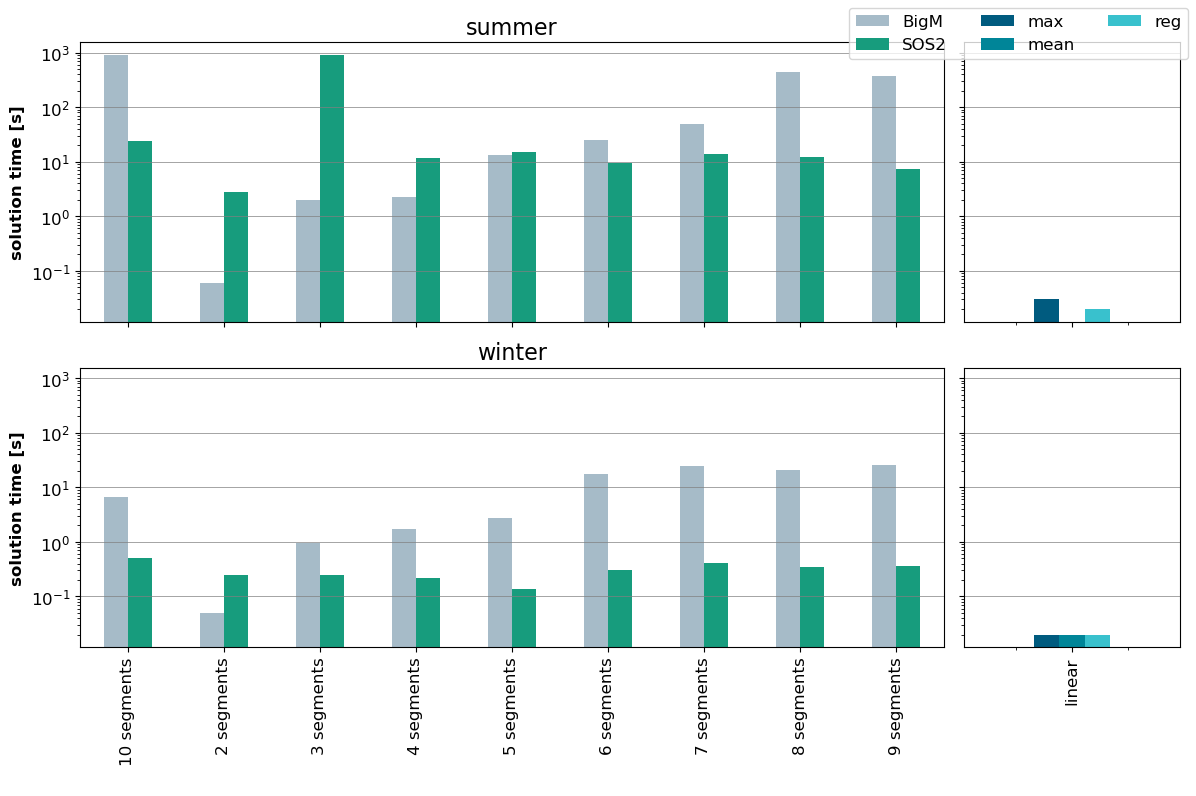

In [1]:
from plots.opt_results_comparison import (
    plot_comparison_optimization_results_phs,
)

type = "solution_time"

plot_comparison_optimization_results_phs(type, "SOS2", "10 segments")



As expected the purely linear approximation solves the fastest and the solution time generally increases with the number of segments and in some cases reaches the limit of 900 s. While this is true both for using SOS2-variables as well as using a Big-M-approach, the Big-M-approach leads to much higher solution times than using SOS2-variables, with the exception of the implementation with three segments (summer data), where using SOS2-variables leads to a high solution time. There is also a significant difference between the runs with the summer data vs. the runs with the winter data. While for the winter data, all model variants solve in less than 21 s (and the SOS2-implementation in less than 0.5 s), for the summer data the solution time for the Big-M-implementation increases drastically with the number of segments and exceeds 900 s three times. The SOS2-implementation also takes longer compared to the winter data, with solution times generally higher than 15 s and up to 105 s and in one case above 900 s. 

> The solution time indeed depends on the number of segments chosen for the piecewise linearization. But it is also highly sensitive to the data of the case study, which can significantly enhance the influence of the number of segments. Judging from the analyzed case study, the number of segments should be less than seven segments to achieve reasonable solution times. Nevertheless, it can not be ruled out that high solution times occur even with smaller numbers of segments.

> Generally it seems to be faster to use the SOS2-variables approach.


**Objective value**

The following plot shows the value of the objective function for the above shown cases. It also details the devation of the objective function to the objective function value of the SOS-2 implementation with 10 segments, implying that this is the most accurate representation available.

Change `comparison method` and `comparison run` to set the reference run.

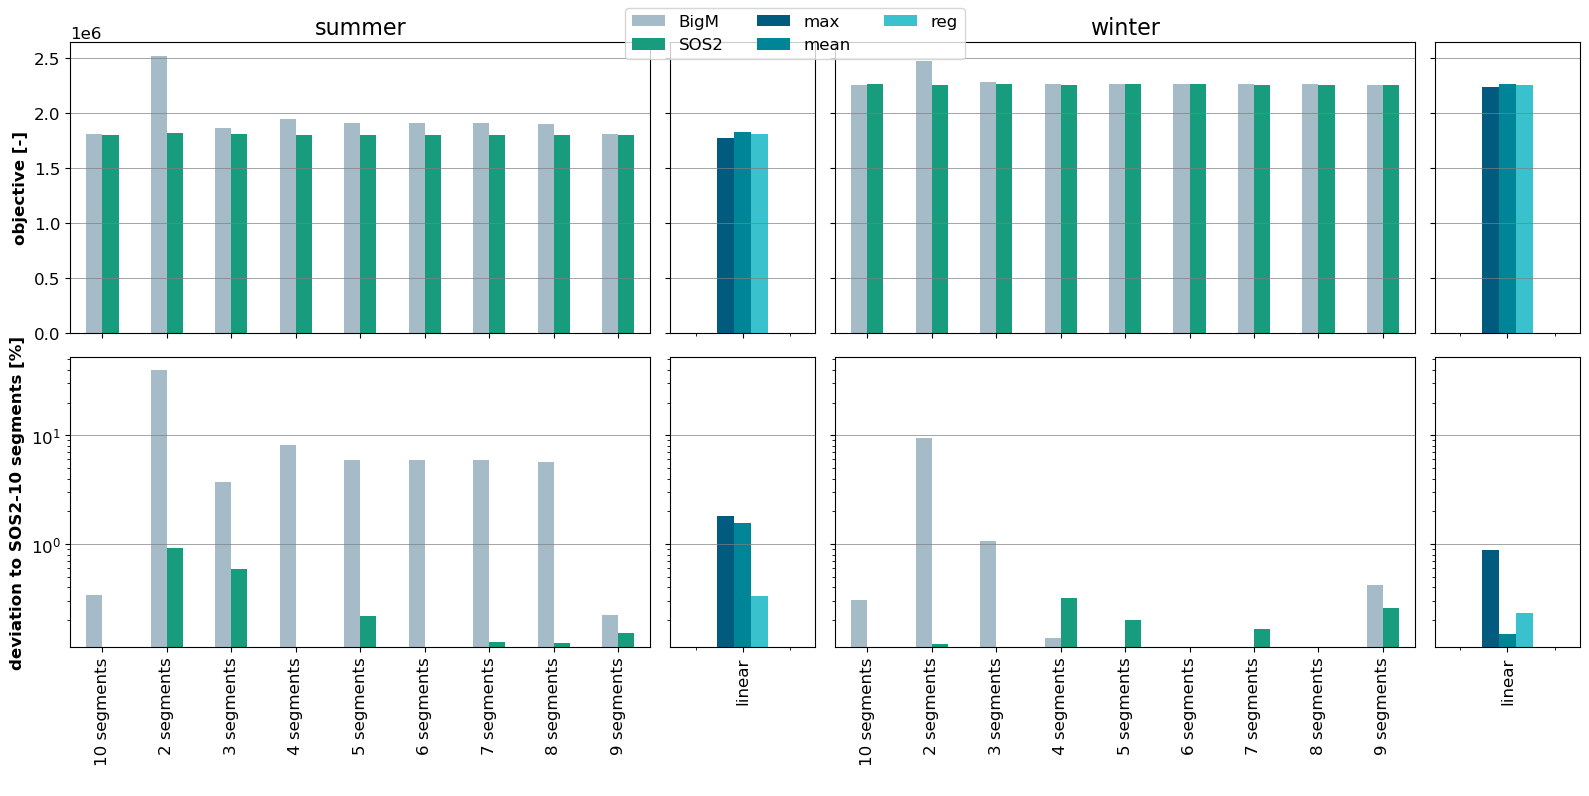

In [2]:
from plots.opt_results_comparison import (
    plot_comparison_optimization_results_phs,
)

type = "objective"
comparison_method = "SOS2"  # BigM, SOS2, max, mean, reg
comparison_run = "10 segments"  # linear, 2 segments, 3 segments,..., 10 segments

plot_comparison_optimization_results_phs(type, comparison_method, comparison_run)


It can be seen that for the SOS-2 implementation the deviation between different numbers of segments is smaller than 1%, which means it is within the range of the MipGap and no conclusion regarding the implementation method can be drawn.

The Big M implementation deviates from the SOS 2 implementation significantly (meaning > 1%) for the summer week and for small numbers of segments in the winter week, overall calculating a slightly higher objective value.

Interestingly the deviation of the linear model is - with one exception - within 1% as well.

> From the objective function values no clear conclusion can be drawn to which implementation is the most accurate.



### simulation of storage schedules

In order to analyze the storage operation schedule derived from the optimization model, we used this schedule as a set point for the simulation, effectively simulating the execution of the schedule derived from the optimization model. This gives an insight, how the operation of a real storage system deviates from the idealistic schedule of the optimization model.



Use the code below to have a look at the deviation of the optimization model to the simulation model for different kpi. (Be aware that for 2 segments only the results for SOS2 are available)

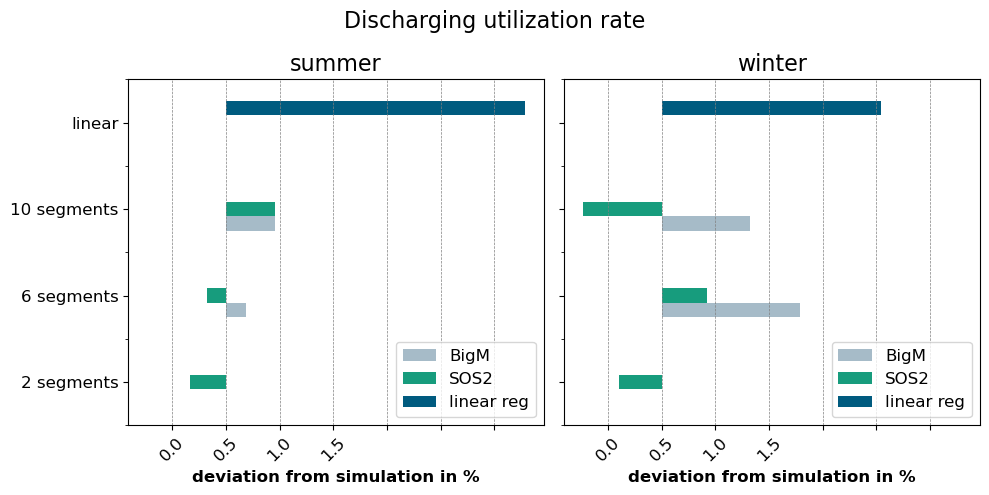

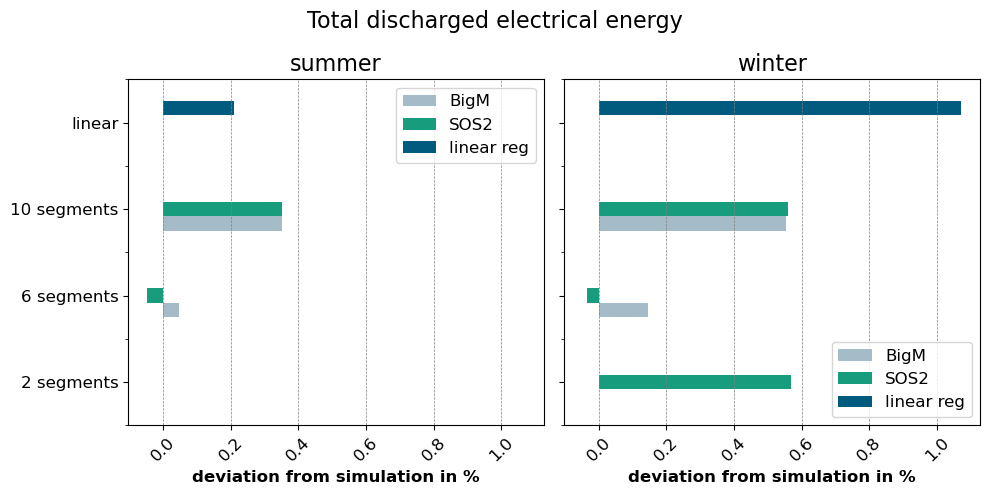

In [3]:
from plots.deviation_to_simulation import plot_kpi

# ------------------------------------------------------------------------------
# Available kpi:
#
# Average charging efficiency
# Average discharging efficiency
# Charging utilization rate
# Discharging utilization rate
# Total charged electrical energy
# Total discharged electrical energy
# Total charging duration
# Total discharging duration
# ------------------------------------------------------------------------------

# plot the deviation of the optimization model results to the simulation model results
# you can change the kpi

plot_kpi("Discharging utilization rate")

plot_kpi("Total discharged electrical energy")


Looking at the different kpi, it is obvious that no systematic effect can be identified.

**Conclusion**

As shown the above results do not allow to determine a "best model approximation". 

A comprehensive sensitivity analysis regarding the case study would be necessary to draw robust conclusion regarding the granularity of the model.

From the limited data in our case, it seems the linear model is actually a great trade off between accuracy and solution time.